# Seasonality
Create indicators and Fourier features to capture periodic change.

# 🌦️ Seasonality in Time Series

## 🌀 What is Seasonality?
Seasonality refers to **regular, periodic changes** in the average value of a time series that occur at fixed intervals. These can be:
- **Daily** (e.g., traffic peaks in the morning)
- **Weekly** (e.g., fewer Wikipedia views on weekends)
- **Yearly** (e.g., ice cream sales peak in summer)

Seasonality is often driven by:
- **Natural cycles** (like weather or daylight)
- **Social behaviors** (like weekends or holidays)

---

## 📊 Seasonal Plots
To detect seasonal patterns, we use **seasonal plots**:
- Plot data for each season (e.g., each week) overlaid to see the repeating pattern.

> Example: Daily Wikipedia views of "Trigonometry" show higher activity on weekdays.

---

## 🔘 Seasonal Indicators (One-Hot Encoding)
When the seasonal period is short (like 7 days), use **binary features** to represent each part of the cycle.

### Example: Weekly Seasonality
| Date       | Tuesday | Wednesday | Thursday | Friday | Saturday | Sunday |
|------------|---------|-----------|----------|--------|----------|--------|
| 2016-01-04 | 0       | 0         | 0        | 0      | 0        | 0      |
| 2016-01-05 | 1       | 0         | 0        | 0      | 0        | 0      |
| 2016-01-05 | 0       | 1         | 0        | 0      | 0        | 0      |

- Each column is 1 only on its corresponding day.
- One day (e.g., Monday) is left out as the **baseline** for regression.
- Linear regression uses these indicators to learn different mean values per day.

---

## 🎵 Fourier Features
When the seasonal cycle is long (e.g., 365 days), indicators are **inefficient**. Use **Fourier features** instead.

### Why Fourier?
- They use **sine and cosine waves** to model periodic behavior.
- Each sine/cosine pair corresponds to a **frequency** (e.g., once a year, twice a year, etc.)
- These features are **continuous** and require **fewer columns**.

### Example: Annual Seasonality
We can model with pairs like:
- `sin(2π * t / 365)` and `cos(2π * t / 365)` (1 cycle/year)
- `sin(2π * 2t / 365)` and `cos(2π * 2t / 365)` (2 cycles/year)
- Up to N pairs, depending on complexity.

---

## 📈 Choosing Fourier Features: The Periodogram
To decide how many Fourier pairs to include:
- Use a **periodogram**: shows the strength of frequencies in the data.
- Look for **peaks** (strong seasonal components).
- Choose a number of pairs that capture the main seasonal frequencies.

> Tip: Use Fourier features for **long seasons**, indicators for **short ones**.

---

## 🧮 Computing Fourier Features (Optional)
You can compute Fourier features manually using:
```python
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq='A', order=4)  # Annual seasonality, 4 pairs
dp = DeterministicProcess(index, constant=True, order=1, seasonal=True, additional_terms=[fourier])
X = dp.in_sample()


In [3]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


comp_dir = Path(r'C:\Users\samad\OneDrive\Bureau\ml\times_series\store_sales_dataset')

holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)
average_sales.head()

C:\Users\samad\AppData\Local\Temp\ipykernel_39168\1055396408.py:12: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  holidays_events = pd.read_csv(
C:\Users\samad\AppData\Local\Temp\ipykernel_39168\1055396408.py:26: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv(


date
2017-01-01      6.780303
2017-01-02    786.928406
2017-01-03    619.740234
2017-01-04    555.607971
2017-01-05    436.375397
Freq: D, Name: sales, dtype: float32

# Examining the seasonal plot:

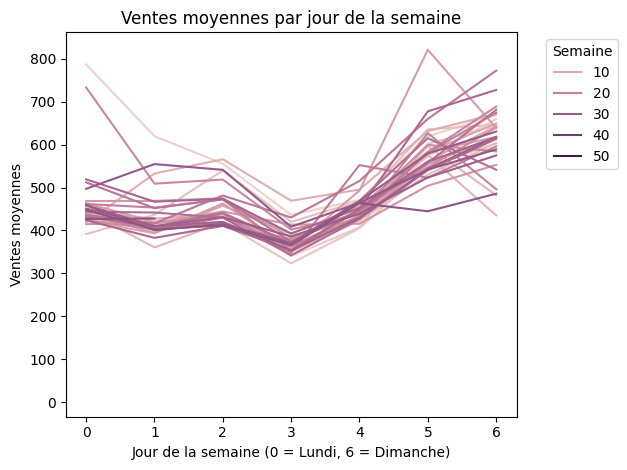

In [4]:

X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
sns.lineplot(data=X, x="day", y="sales", hue="week")
plt.title("Ventes moyennes par jour de la semaine")
plt.xlabel("Jour de la semaine (0 = Lundi, 6 = Dimanche)")
plt.ylabel("Ventes moyennes")
plt.legend(title="Semaine", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Periodigram:

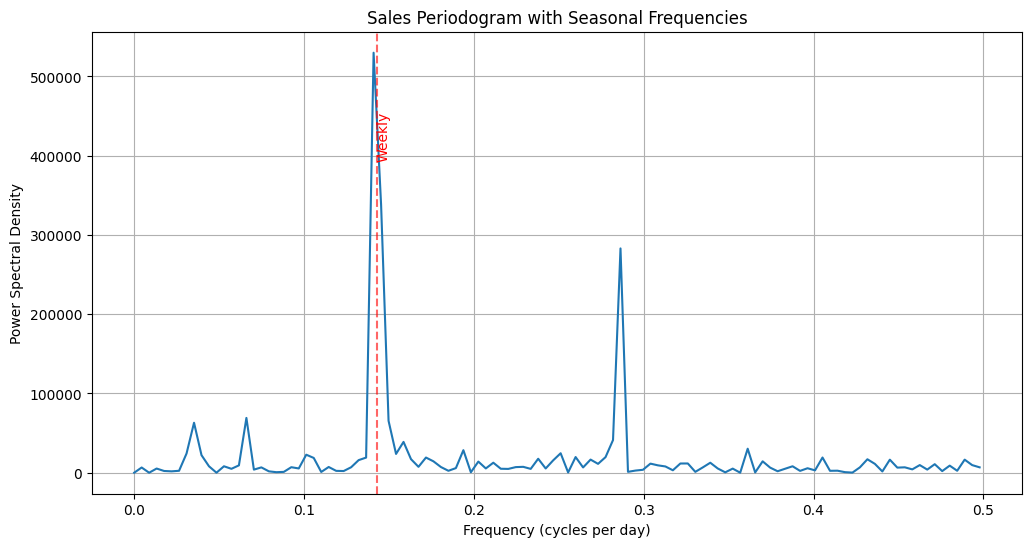

In [5]:
from scipy.signal import periodogram
# Sampling frequency (1 sample per day)
fs = 1  

# Compute the periodogram
frequencies, power = periodogram(average_sales.values, fs=fs)

# Define major seasonal frequencies
seasonal_freqs = {
    'Weekly': 1/7
}

# Plot
plt.figure(figsize=(12, 6))
plt.plot(frequencies, power, label='Periodogram')
plt.title("Sales Periodogram with Seasonal Frequencies")
plt.xlabel("Frequency (cycles per day)")
plt.ylabel("Power Spectral Density")
plt.grid(True)

# Add vertical lines and labels for known cycles
for label, freq in seasonal_freqs.items():
    plt.axvline(x=freq, color='red', linestyle='--', alpha=0.6)
    plt.text(freq, max(power)*0.8, label, rotation=90, verticalalignment='center', color='red')


## 1) Determine seasonality
A clear peak appears at 0.14, which corresponds to a frequency of 1/7 — suggesting a weekly seasonal pattern.

## 2) Create seasonal features
    - Indicators for weekly seasons and
    - Fourier features of order 4 for monthly seasons.

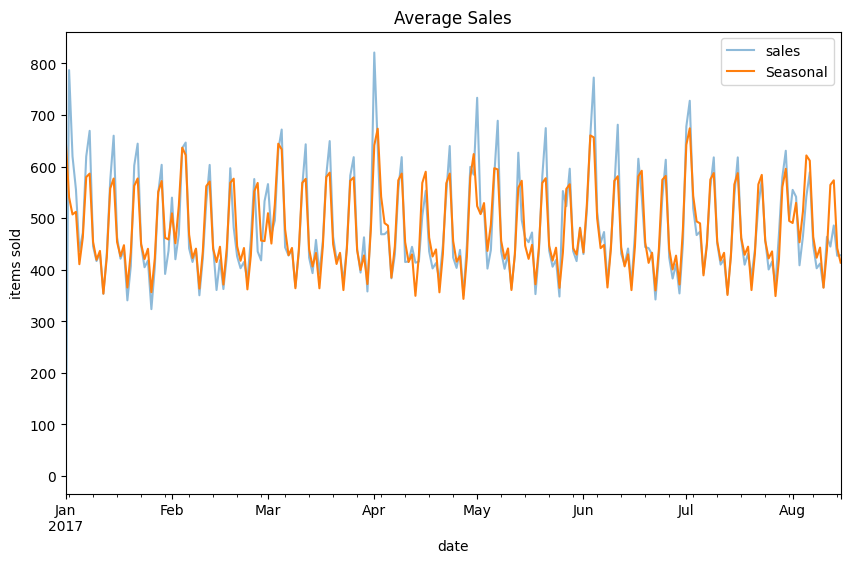

In [6]:
# Copy the target series (sales) to 'y'
y = average_sales.copy()

# -------------------------------------------------------------
# Create Fourier terms to model annual seasonality
# freq="ME" means Month-End frequency (e.g., Jan 31, Feb 28, etc.)
# order=4 means we're including 4 sine/cosine pairs
# -------------------------------------------------------------
fourier = CalendarFourier(freq="ME", order=4)
# -------------------------------------------------------------
# Create a deterministic process for time series regression
dp = DeterministicProcess(
    index=y.index,
    constant=True,               # Adds intercept term
    order=1,                     # Linear trend (order=1)
    seasonal=True,               # Weekly seasonality (day-of-week dummies)
    additional_terms=[fourier],  # Fourier terms for annual seasonality
    drop=True,                   # Drop first dummy of each set to avoid multicollinearity
)

# -------------------------------------------------------------
# Generate the feature matrix (X) for in-sample prediction
# This matches the time index of y
# -------------------------------------------------------------
X = dp.in_sample()
# -------------------------------------------------------------
# Fitting the Seasonal Model:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)
plot_params = {'figsize': (10, 6)}
y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend()


--> Removing from a series its trend or seasons is called detrending or deseasonalizing the series:

Text(0.5, 1.0, 'Deseasonalized')

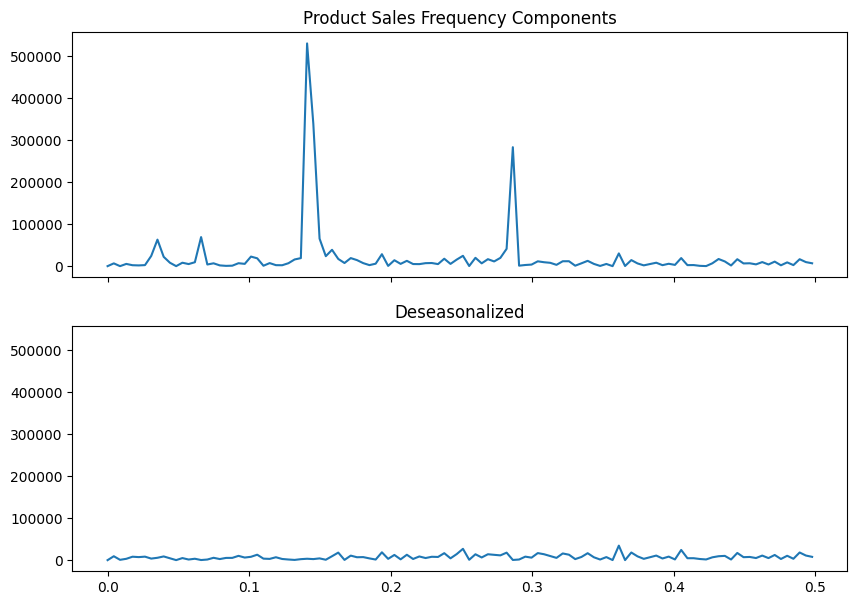

In [7]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
frequencies, power = periodogram(y.values, fs=fs)
ax1.plot(frequencies, power)
ax1.set_title("Product Sales Frequency Components")
frequencies, power = periodogram(y_deseason.values, fs=fs)
ax2.plot(frequencies, power)
ax2.set_title("Deseasonalized")

## 3) Check for remaining seasonality:
    Based on these periodograms, how effectively does it appear our model captured the seasonality in Average Sales? Does the periodogram agree with the time plot of the deseasonalized series?

    --> Response: The periodogram for the deseasonalized series lacks any large values. By comparing it to the periodogram for the original series, we can see that our model was able to capture the seasonal variation in Average Sales.



-------------------------------------------------------------------------------

The *Store Sales* dataset includes a table of Ecuadorian holidays.

In [8]:
# National and regional holidays in the training set
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


From a plot of the deseasonalized Average Sales, it appears these holidays could have some predictive power.

C:\Users\samad\AppData\Local\Temp\ipykernel_39168\2418862508.py:2: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')


Text(0.5, 1.0, 'National and Regional Holidays')

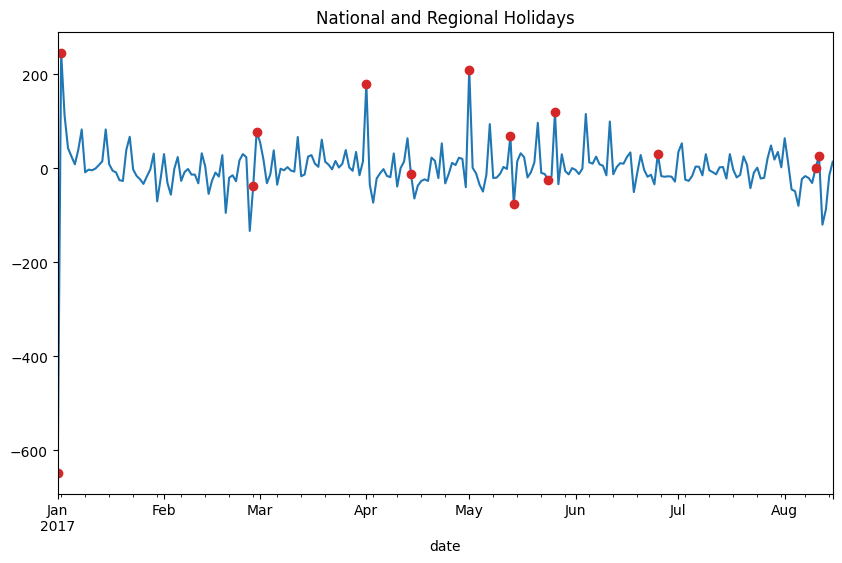

In [9]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays')

## 4) Create holiday features
What kind of features could we create to help our model make use of this information?

In [10]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

X_holidays = pd.DataFrame(
    ohe.fit_transform(holidays['description'].values.reshape(-1, 1)).toarray(),
    index=holidays.index,
    columns=holidays.description.unique(),
)


# Pandas solution
X_holidays = pd.get_dummies(holidays)


# Join to training data
X2 = X.join(X_holidays, on='date').fillna(0.0)

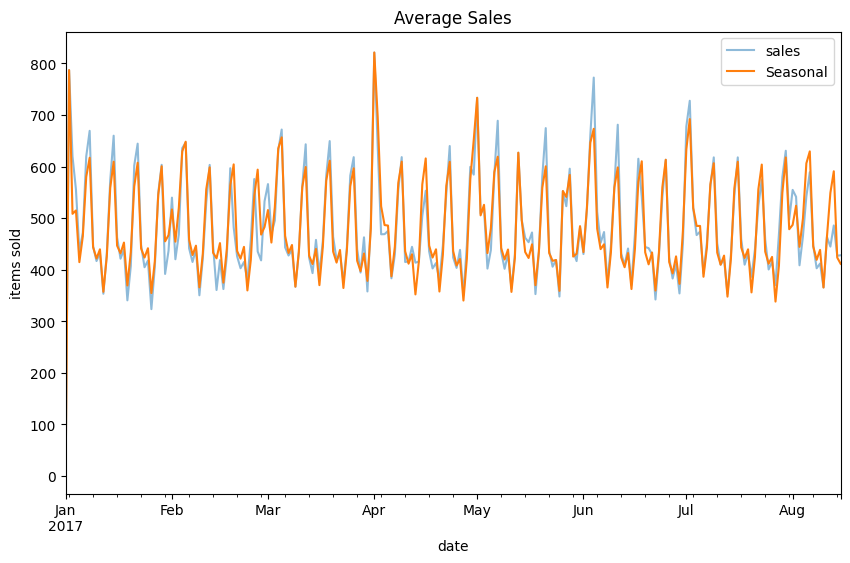

In [11]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend()

 After fitting  the seasonal model with holiday features added, the fitted values seem to have improved!!

# 📤 Submit to Store Sales Competition

we're now ready to apply what we've learned by submitting a forecast to the Kaggle competition:  
👉 [**Store Sales - Time Series Forecasting**](https://www.kaggle.com/c/29781)

---

## ✅ What This Step Does

In this final step:
1. A **seasonal model** is trained using the complete *Store Sales* dataset (covering all **1800 time series**).
2. The model makes **predictions** for the **forecast period** (i.e., future dates in the test set).
3. It creates a **feature set** with seasonal indicators and/or Fourier features, just like we learned.
4. The forecasted values are saved in a file:  
   📄 `submission.csv`
5. we can then upload this file to Kaggle as our competition **submission**.

---

## 🛠️ What's Included in the Model
- Seasonal features such as **day-of-week** or **annual seasonality**
- Possibly **trend**, **holiday**, or **promotion effects**
- A model like **linear regression** fit to each time series


In [12]:
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

c:\Users\samad\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\deterministic.py:569: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


Text(0.5, 1.0, 'PRODUCE Sales at Store 1')

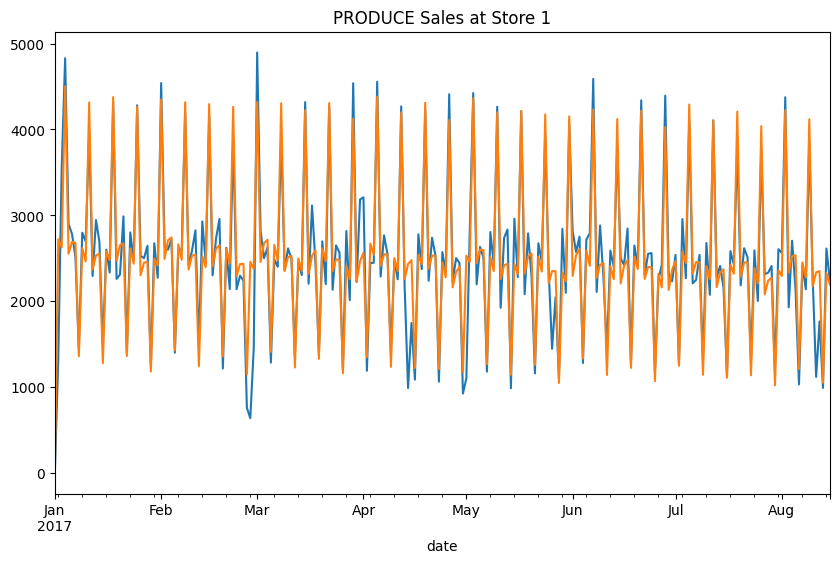

In [13]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'PRODUCE'
# Uncomment to see a list of product families
# display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}')

In [14]:
df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)


y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)

C:\Users\samad\AppData\Local\Temp\ipykernel_39168\582161191.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_test = pd.read_csv(
C:\Users\samad\AppData\Local\Temp\ipykernel_39168\582161191.py:21: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y_submit = y_submit.stack(['store_nbr', 'family'])
